In [ ]:
pip install -r requirements.txt

# ICU Transfusion Threshold Analysis with Shock Flagging and Fairness Review

This notebook analyzes real-world ICU transfusion practices in adult patients to determine if they align with the 7 g/dL hemoglobin threshold guideline, with a focus on patients with shock. We'll also examine potential disparities or biases in transfusion practices based on demographic and care setting factors.

## 1. Data Loading and Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap
import statsmodels.api as sm
from scipy import stats

# Set visualization styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Load the datasets
try:
    df_main = pd.read_csv('eicu_transfused_patient_data_with_all_variables.csv')
    df_vasopressor = pd.read_csv('vasopressor_patients.csv')

    print(f"Main dataset shape: {df_main.shape}")
    print(f"Vasopressor dataset shape: {df_vasopressor.shape}")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")

Main dataset shape: (2098, 72)
Vasopressor dataset shape: (269, 8)


## 2. Initial Data Exploration and Cleanup

In [3]:
# Check main dataset columns
print("Main dataset columns:")
print(df_main.columns.tolist())

# Check for missing values in main dataset
missing_values = df_main.isnull().sum()
missing_percent = (missing_values / len(df_main)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

print("\nColumns with highest percentage of missing values:")
display(missing_df.head(10))

# Check data types
print("\nData types:")
display(df_main.dtypes)

Main dataset columns:
['patientunitstayid', 'pat_gender', 'age', 'ethnicity', 'apacheadmissiondx', 'hospitalid', 'celllabel', 'intakeoutputoffset', 'cellvaluenumeric', 'cellvaluetext', 'hemoglobin', 'Hematocrit', 'Platelets', 'PT_INR', 'PTT', 'Vancomycin_peak', 'apachepatientresultsid', 'patientunitstayid_2', 'physicianspeciality', 'physicianinterventioncategory', 'acutephysiologyscore', 'apachescore', 'apacheversion', 'predictedicumortality', 'actualicumortality', 'predictediculos', 'actualiculos', 'predictedhospitalmortality', 'actualhospitalmortality', 'predictedhospitallos', 'actualhospitallos', 'preopmi', 'preopcardiaccath', 'ptcawithin24h', 'unabridgedunitlos', 'unabridgedhosplos', 'actualventdays', 'predventdays', 'unabridgedactualventdays', 'rn', 'vent', 'dialysis', 'temperature', 'respiratoryrate', 'heartrate', 'meanbp', 'ph', 'aps_hematocrit', 'aps_pao2', 'apachepredvarid', 'saps3day1', 'saps3today', 'saps3yesterday', 'pred_gender', 'admitdiagnosis', 'pred_pao2', 'diagnosis_s

,Missing Values,Percentage
Vancomycin_peak,2098,100.000000
infusion_drugs_summary,2098,100.000000
allergy_drugs_summary,2098,100.000000
admission_drugs_summary,2098,100.000000
padiastolic,1751,83.460439
pasystolic,1751,83.460439
pamean,1747,83.269781
predventdays,1396,66.539561
actualventdays,1380,65.776930
unabridgedactualventdays,1380,65.776930



Data types:


patientunitstayid      int64
pat_gender            object
age                   object
ethnicity             object
apacheadmissiondx     object
                      ...   
padiastolic          float64
pamean               float64
numbedsCategory       object
teachingstatus          bool
region                object
Length: 72, dtype: object

In [4]:
# Check for any generic feature names like Feature_89
generic_feature_pattern = r'Feature_\d+'
generic_columns = [col for col in df_main.columns if pd.Series(col).str.match(generic_feature_pattern).any()]

if generic_columns:
    print(f"Found {len(generic_columns)} generic feature names. Example: {generic_columns[:5]}")
else:
    print("No generic feature names found in the dataset.")

No generic feature names found in the dataset.


## 3. Merge Datasets and Create Shock Flag

In [5]:
# Display sample data from both datasets
print("Main dataset sample:")
display(df_main.head(3))

print("\nVasopressor dataset sample:")
display(df_vasopressor.head(3))

# Find common key column
common_columns = set(df_main.columns).intersection(set(df_vasopressor.columns))
print(f"\nCommon columns between datasets: {common_columns}")

# Use patientunitstayid as the key column
key_column = 'patientunitstayid'
print(f"\nUsing '{key_column}' as the key column")

# Check data types of the key column in both datasets to ensure compatibility
print(f"\nData type in main dataset: {df_main[key_column].dtype}")
print(f"Data type in vasopressor dataset: {df_vasopressor[key_column].dtype}")

# Convert to same type if necessary
if df_main[key_column].dtype != df_vasopressor[key_column].dtype:
    print("Converting key column to the same data type in both datasets...")
    if df_main[key_column].dtype == 'int64':
        df_vasopressor[key_column] = df_vasopressor[key_column].astype('int64')
    else:
        df_main[key_column] = df_main[key_column].astype(str)
        df_vasopressor[key_column] = df_vasopressor[key_column].astype(str)

Main dataset sample:


,patientunitstayid,pat_gender,age,ethnicity,apacheadmissiondx,hospitalid,celllabel,intakeoutputoffset,cellvaluenumeric,cellvaluetext,...,systemicsystolic,systemicdiastolic,systemicmean,sao2,pasystolic,padiastolic,pamean,numbedsCategory,teachingstatus,region
0,154458,Male,63,Caucasian,"CABG alone, redo",71,Volume-Transfuse red blood cells,-62,250.0,250.0,...,77.0,40.0,51.0,89.0,27.0,13.0,21.0,100 - 249,False,Midwest
1,166280,Male,64,Caucasian,"Hemorrhage, intra/retroperitoneal",71,Volume-Transfuse red blood cells,137,416.0,416.0,...,NaN,NaN,NaN,96.0,NaN,NaN,NaN,100 - 249,False,Midwest
2,168968,Female,75,Caucasian,"Hemorrhage/hematoma, intracranial",73,Volume-Transfuse red blood cells,-1219,350.0,350.0,...,NaN,NaN,NaN,79.0,NaN,NaN,NaN,>= 500,True,Midwest



Vasopressor dataset sample:


,patientunitstayid,norepinephrine,epinephrine,dopamine,dobutamine,phenylephrine,vasopressin,milrinone
0,146512,1,0,0,0,0,0,0
1,146512,0,0,0,0,0,1,0
2,155278,0,0,0,1,0,0,0



Common columns between datasets: {'patientunitstayid'}

Using 'patientunitstayid' as the key column

Data type in main dataset: int64
Data type in vasopressor dataset: int64


In [6]:
# Create a set of unique patient IDs that received vasopressors
vasopressor_ids = set(df_vasopressor[key_column].unique())
print(f"Number of unique patients in vasopressor dataset: {len(vasopressor_ids)}")

# Add shock flag to main dataset based on presence in vasopressor list
df_main['shock_based_upon_vasopressor_given'] = df_main[key_column].apply(
    lambda x: 1 if x in vasopressor_ids else 0
)

# Verify shock flag creation
shock_count = df_main['shock_based_upon_vasopressor_given'].sum()
total_patients = len(df_main)

print(f"\nPatients flagged as shock (vasopressor given): {shock_count} of {total_patients} "
      f"({shock_count / total_patients * 100:.2f}%)")

# Preview some flagged cases
print("\nSample patients with shock flag = 1:")
display(df_main[df_main['shock_based_upon_vasopressor_given'] == 1].head())

Number of unique patients in vasopressor dataset: 107

Patients flagged as shock (vasopressor given): 107 of 2098 (5.10%)

Sample patients with shock flag = 1:


,patientunitstayid,pat_gender,age,ethnicity,apacheadmissiondx,hospitalid,celllabel,intakeoutputoffset,cellvaluenumeric,cellvaluetext,...,systemicdiastolic,systemicmean,sao2,pasystolic,padiastolic,pamean,numbedsCategory,teachingstatus,region,shock_based_upon_vasopressor_given
4,143399,Male,83,Caucasian,Aortic and Mitral valve replacement,73,Volume-Transfuse red blood cells,90,325.0,325.0,...,28.0,41.0,66.0,22.0,11.0,17.0,>= 500,True,Midwest,1
5,144770,Male,85,Caucasian,"CVA, cerebrovascular accident/stroke",71,Volume-Transfuse red blood cells,1222,250.0,250.0,...,-5.0,-4.0,71.0,23.0,13.0,17.0,100 - 249,False,Midwest,1
51,154837,Male,79,Caucasian,"Endarterectomy, carotid",63,Volume-Transfuse red blood cells,977,348.0,348.0,...,18.0,33.0,79.0,NaN,NaN,NaN,100 - 249,False,Midwest,1
57,145639,Female,65,Caucasian,Tricuspid valve surgery,73,Volume-Transfuse red blood cells,285,350.0,350.0,...,38.0,28.0,90.0,10.0,0.0,5.0,>= 500,True,Midwest,1
62,154389,Female,77,Caucasian,Tricuspid valve surgery,73,Volume-Transfuse red blood cells,1280,325.0,325.0,...,18.0,32.0,90.0,10.0,5.0,8.0,>= 500,True,Midwest,1


## 4. Create Target Variable

We'll create a binary target variable based on the hemoglobin level, which will indicate whether a patient was transfused with hemoglobin levels at or above the 7 g/dL threshold.

In [7]:
# Create the target variable based on hemoglobin level
df_main['transfused_above_7'] = df_main['hemoglobin'].apply(lambda x: 1 if x >= 7 else 0)

# Verify the target variable creation
transfused_above_7_count = df_main['transfused_above_7'].sum()
print(f"Patients transfused with Hb ≥ 7 g/dL: {transfused_above_7_count} ({transfused_above_7_count/len(df_main)*100:.2f}% of total)")

# Display distribution by shock status
transfusion_by_shock = pd.crosstab(
    df_main['shock_based_upon_vasopressor_given'],
    df_main['transfused_above_7'],
    normalize='index')

transfusion_by_shock.columns = ['Hb < 7 g/dL', 'Hb ≥ 7 g/dL']
transfusion_by_shock.index = ['No Shock', 'Shock']
display(transfusion_by_shock.style.format("{:.1%}"))

Patients transfused with Hb ≥ 7 g/dL: 1116 (53.19% of total)


,Hb < 7 g/dL,Hb ≥ 7 g/dL
No Shock,47.0%,53.0%
Shock,43.9%,56.1%


## 5. Data Exploration and Visualization

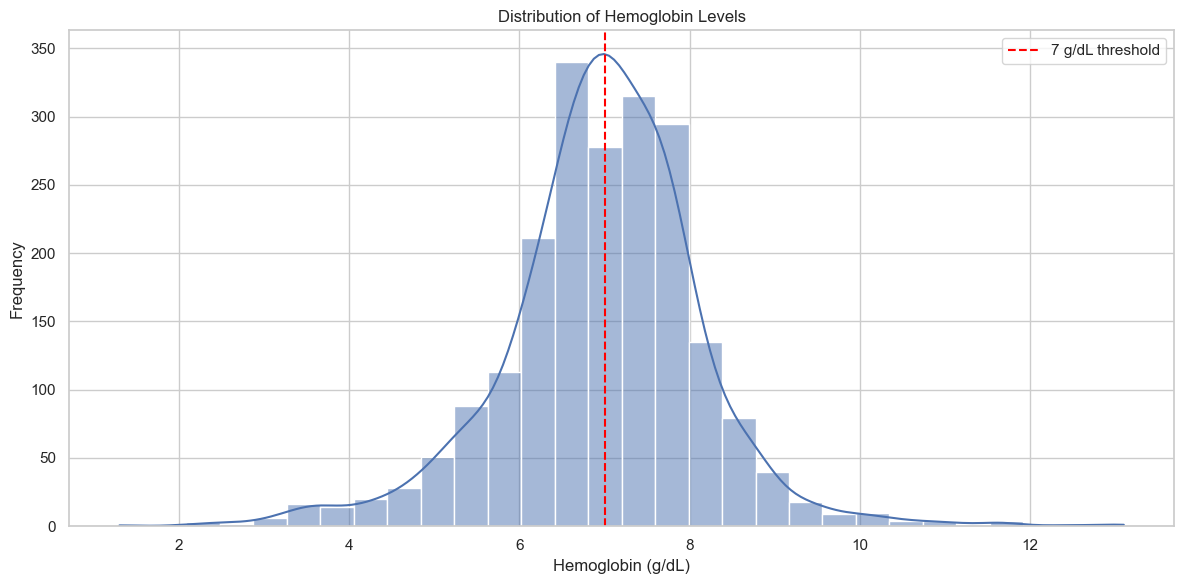

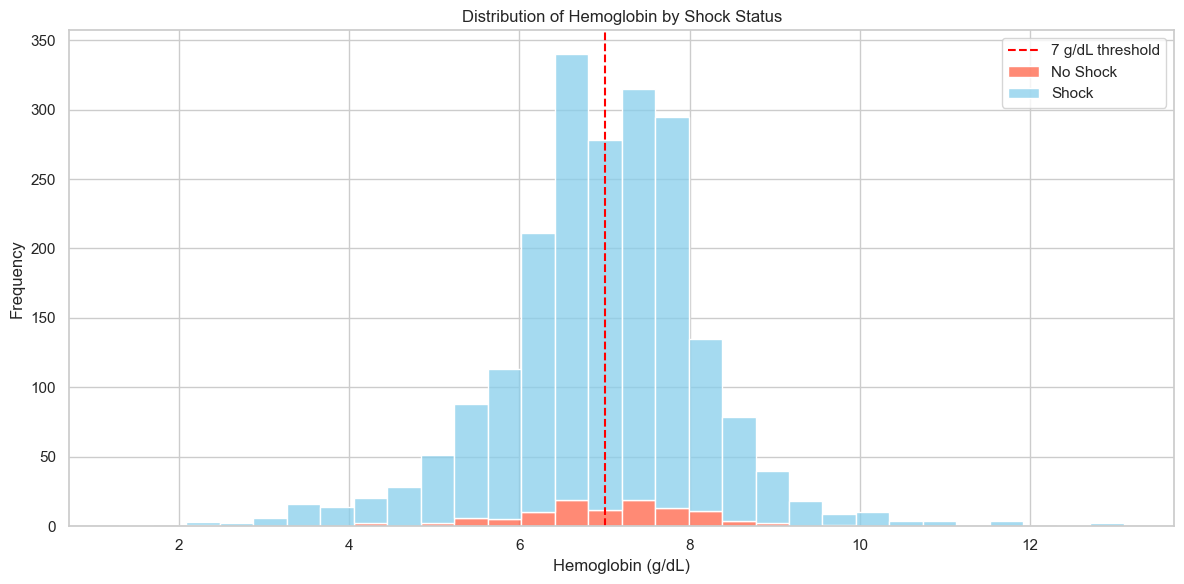

In [8]:
# Explore the distribution of hemoglobin
plt.figure(figsize=(12, 6))
sns.histplot(df_main['hemoglobin'], bins=30, kde=True)
plt.axvline(x=7, color='red', linestyle='--', label='7 g/dL threshold')
plt.title('Distribution of Hemoglobin Levels')
plt.xlabel('Hemoglobin (g/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Separate distributions by shock status
plt.figure(figsize=(12, 6))
sns.histplot(data=df_main, x='hemoglobin', hue='shock_based_upon_vasopressor_given',
             multiple='stack', bins=30, palette=['skyblue', 'tomato'])
plt.axvline(x=7, color='red', linestyle='--', label='7 g/dL threshold')
plt.title('Distribution of Hemoglobin by Shock Status')
plt.xlabel('Hemoglobin (g/dL)')
plt.ylabel('Frequency')
plt.legend(['7 g/dL threshold', 'No Shock', 'Shock'])
plt.tight_layout()
plt.show()

In [9]:
# Explore demographic features
demographic_features = []

# Check for gender column
if 'pat_gender' in df_main.columns:
    df_main.rename(columns={'pat_gender': 'gender'}, inplace=True)
    demographic_features.append('gender')
elif 'gender' in df_main.columns:
    demographic_features.append('gender')

# Check for race/ethnicity column
if 'ethnicity' in df_main.columns:
    df_main.rename(columns={'ethnicity': 'race'}, inplace=True)
    demographic_features.append('race')
elif 'race' in df_main.columns:
    demographic_features.append('race')

# Add insurance and age if available
if 'insurance' in df_main.columns:
    demographic_features.append('insurance')
if 'age' in df_main.columns:
    demographic_features.append('age')

# Remove duplicates
demographic_features = list(set(demographic_features))
print(f"Demographic features for analysis: {demographic_features}")

# Create age groups if needed
if 'age' in df_main.columns:
    # First, ensure age is numeric, handling special cases like '> 89'
    df_main['age_numeric'] = df_main['age'].copy()
    
    # Check if age is already numeric
    if df_main['age'].dtype == object:
        # Replace '> 89' with '90' for binning purposes
        df_main.loc[df_main['age_numeric'] == '> 89', 'age_numeric'] = '90'
        # Convert to numeric, errors='coerce' will turn non-numeric values to NaN
        df_main['age_numeric'] = pd.to_numeric(df_main['age_numeric'], errors='coerce')
    
    # Create the age groups
    df_main['age_group'] = pd.cut(
        df_main['age_numeric'],
        bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
        labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
    )
    # Add age_group to demographic features
    demographic_features.append('age_group')

Demographic features for analysis: ['race', 'gender', 'age']



race distribution:


,race,Count,Percentage
0,Caucasian,1652,78.741659
1,African American,240,11.439466
2,Hispanic,120,5.719733
3,Asian,41,1.954242
4,Native American,15,0.714967
5,Other/Unknown,4,0.190658


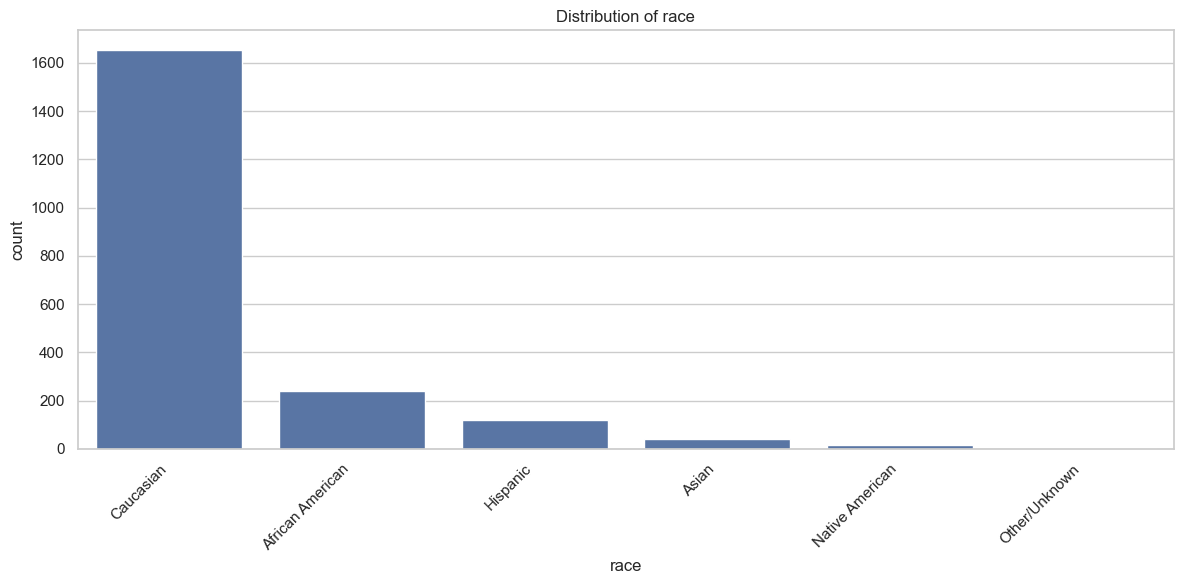


gender distribution:


,gender,Count,Percentage
0,Male,1081,51.525262
1,Female,1017,48.474738


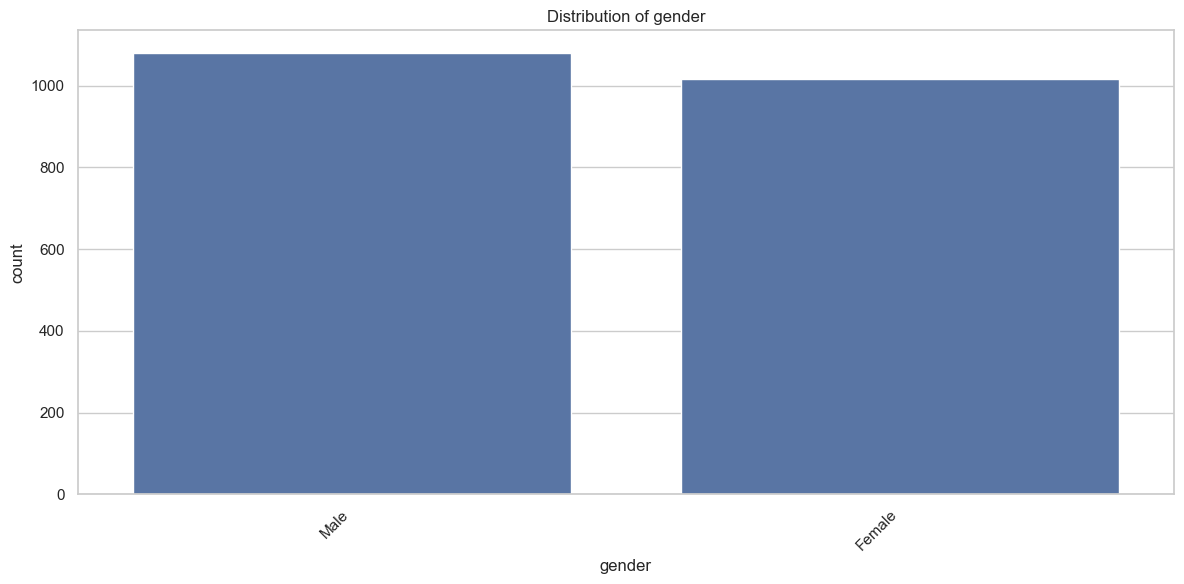


age distribution:


,age,Count,Percentage
0,> 89,80,3.813155
1,64,74,3.527169
2,70,69,3.288847
3,71,62,2.955195
4,63,58,2.764538
...,...,...,...
69,37,2,0.095329
70,21,2,0.095329
71,25,2,0.095329
72,15,1,0.047664


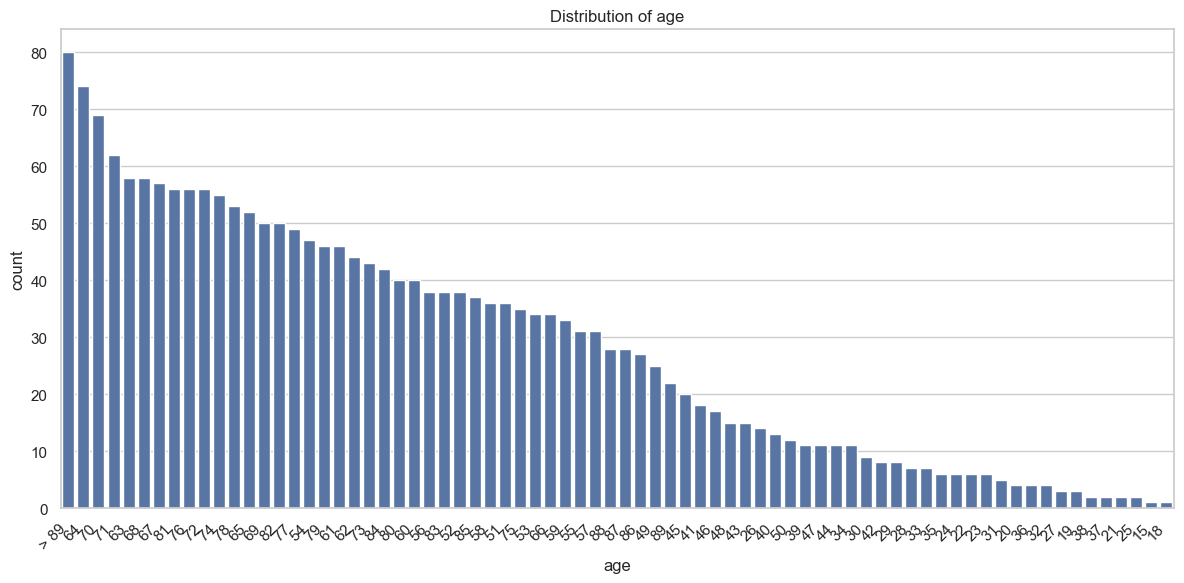


age_group distribution:


,age_group,Count,Percentage
0,60-69,542,25.834128
1,70-79,495,23.593899
2,80-89,408,19.447092
3,50-59,364,17.349857
4,40-49,152,7.244995
5,30-39,65,3.098189
6,20-29,63,3.002860
7,10-19,9,0.428980
8,0-9,0,0.000000
9,90-99,0,0.000000


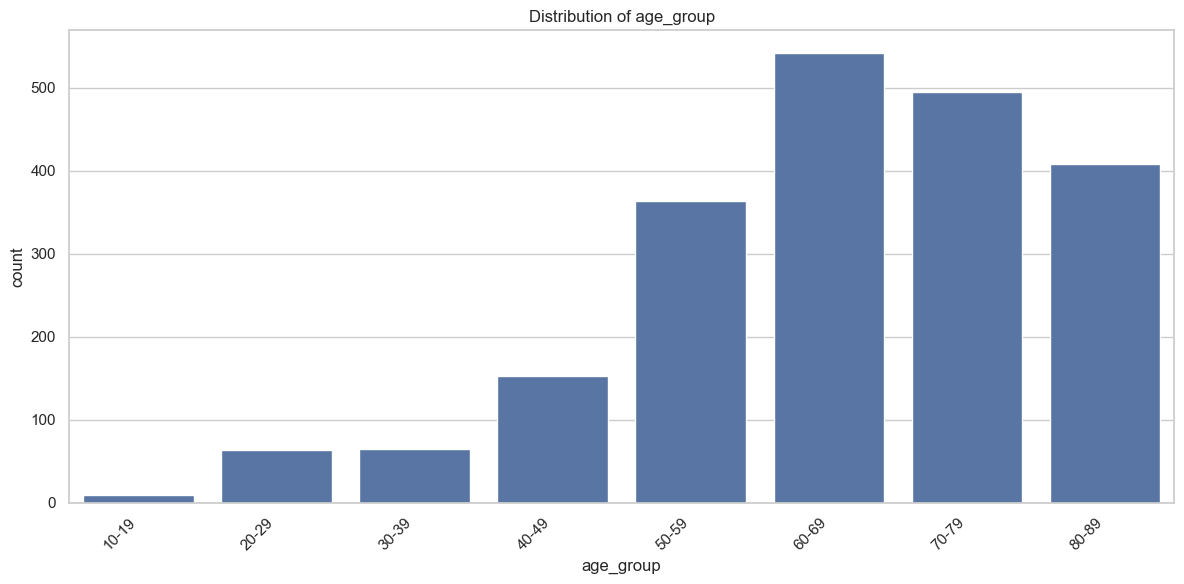

In [10]:
# Create visualizations for demographic features
for feature in demographic_features:
    if feature not in df_main.columns:
        print(f"Warning: Feature '{feature}' not found in dataset")
        continue
        
    if df_main[feature].dtype == 'object' or df_main[feature].nunique() < 15 or feature == 'age_group':
        # For categorical variables
        feature_counts = df_main[feature].value_counts().reset_index()
        feature_counts.columns = [feature, 'Count']
        feature_counts['Percentage'] = feature_counts['Count'] / len(df_main) * 100
        print(f"\n{feature} distribution:")
        display(feature_counts)

        # Create a bar chart
        plt.figure(figsize=(12, 6))
        if feature == 'age_group':
            # For age_group, maintain the decade order
            order = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
            order = [o for o in order if o in df_main['age_group'].unique()]
            sns.countplot(data=df_main, x=feature, order=order)
        else:
            sns.countplot(data=df_main, x=feature, order=feature_counts[feature])
        plt.title(f'Distribution of {feature}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


Transfusion rates by race:


,Hb < 7 g/dL,Hb ≥ 7 g/dL
race,,
African American,60.8%,39.2%
Asian,70.7%,29.3%
Caucasian,42.7%,57.3%
Hispanic,64.2%,35.8%
Native American,60.0%,40.0%
Other/Unknown,50.0%,50.0%


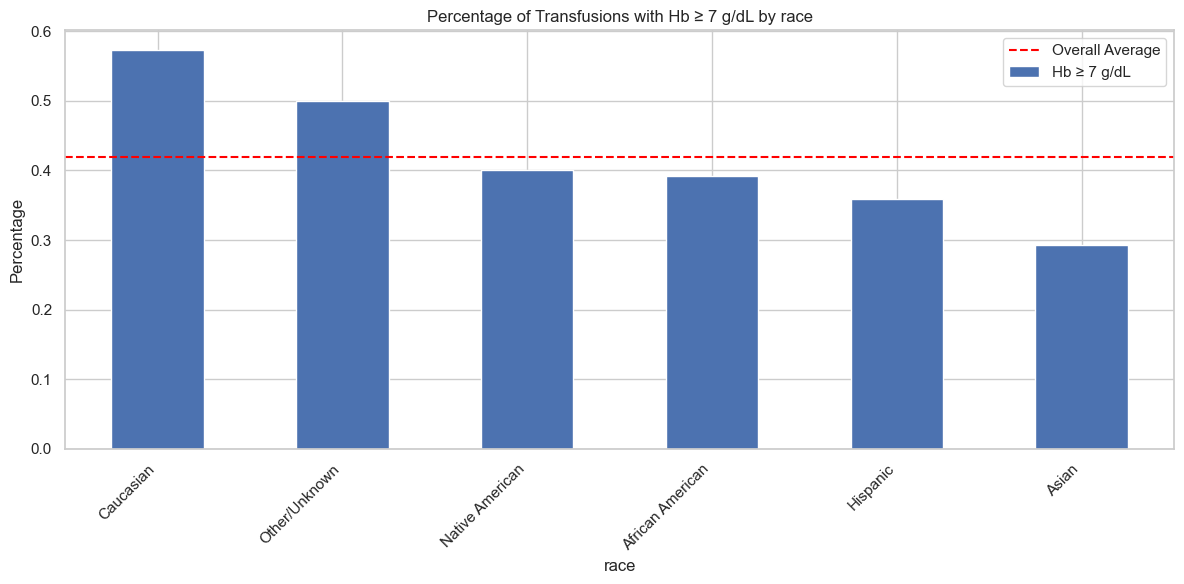


Transfusion rates by gender:


,Hb < 7 g/dL,Hb ≥ 7 g/dL
gender,,
Female,47.4%,52.6%
Male,46.3%,53.7%


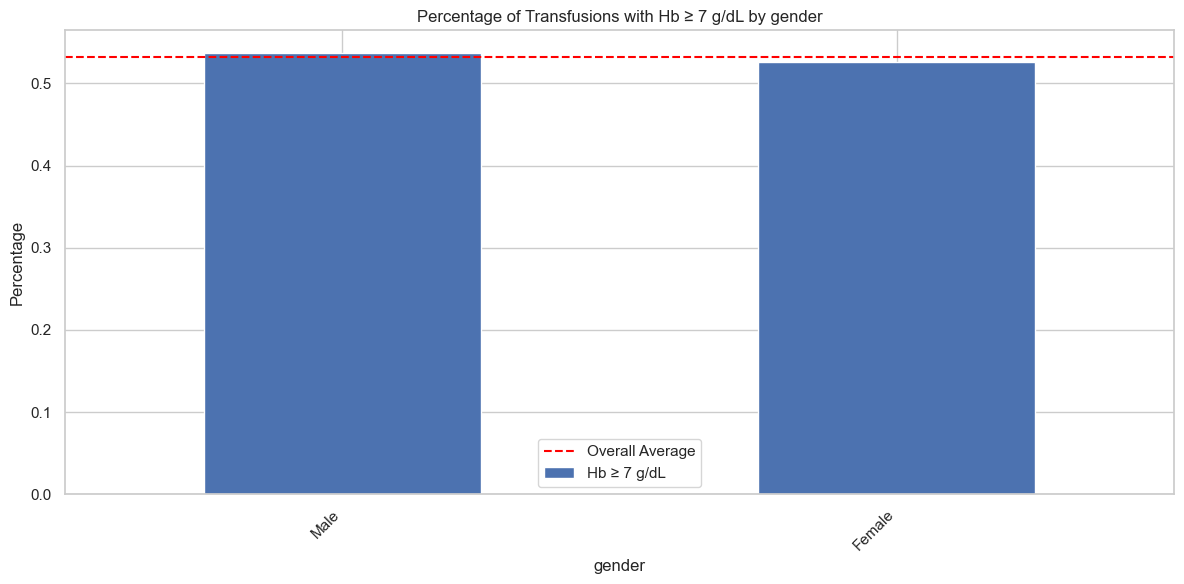


Transfusion rates by age:


,Hb < 7 g/dL,Hb ≥ 7 g/dL
age,,
15,100.0%,0.0%
18,0.0%,100.0%
19,33.3%,66.7%
20,50.0%,50.0%
21,50.0%,50.0%
22,83.3%,16.7%
23,66.7%,33.3%
24,83.3%,16.7%
25,0.0%,100.0%


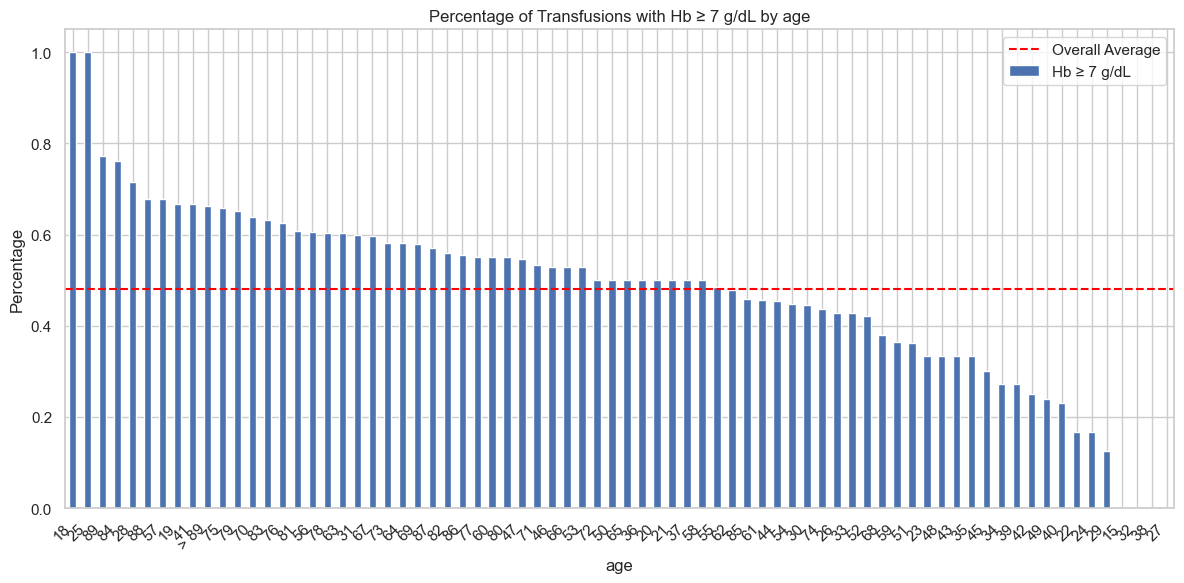


Transfusion rates by age_group:


,Hb < 7 g/dL,Hb ≥ 7 g/dL
age_group,,
10-19,44.4%,55.6%
20-29,63.5%,36.5%
30-39,69.2%,30.8%
40-49,59.2%,40.8%
50-59,50.8%,49.2%
60-69,45.9%,54.1%
70-79,43.6%,56.4%
80-89,37.5%,62.5%


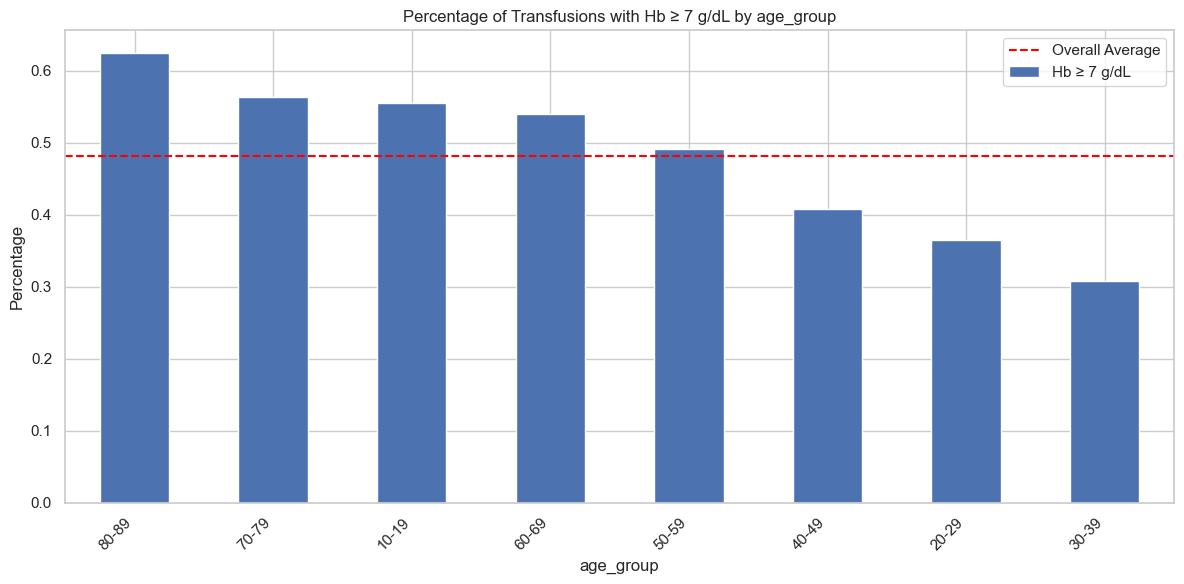

In [11]:
# Explore transfusion rates by demographic features
for feature in demographic_features:
    if feature not in df_main.columns:
        continue
        
    if df_main[feature].dtype == 'object' or df_main[feature].nunique() < 15 or feature == 'age_group':
        # For categorical variables
        transfusion_by_feature = pd.crosstab(
            df_main[feature],
            df_main['transfused_above_7'],
            normalize='index')

        transfusion_by_feature.columns = ['Hb < 7 g/dL', 'Hb ≥ 7 g/dL']
        print(f"\nTransfusion rates by {feature}:")
        display(transfusion_by_feature.style.format("{:.1%}"))

        # Create a bar chart
        plt.figure(figsize=(12, 6))
        transfusion_by_feature['Hb ≥ 7 g/dL'].sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Percentage of Transfusions with Hb ≥ 7 g/dL by {feature}')
        plt.ylabel('Percentage')
        plt.axhline(y=transfusion_by_feature['Hb ≥ 7 g/dL'].mean(), color='red', linestyle='--',
                    label='Overall Average')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 6. Data Preprocessing and Feature Definition

In [12]:
# Define clinical variables of interest
patient_variables = [
    'age', 'age_group', 'gender', 'race',
    'hemoglobin', 'Hematocrit', 'Platelets', 'PT_INR', 'PTT',
    'acutephysiologyscore', 'apachescore', 'aps_pao2',
    'heartrate', 'meanbp', 'sao2', 'systemicmean', 'temperature', 'respiratoryrate'
]

provider_variables = [
    'teachingstatus', 'region', 'hospitalid', 'numbedsCategory',
    'physicianspeciality', 'intakeoutputoffset'
]

# Check which variables are available in the dataset
available_patient_vars = [var for var in patient_variables if var in df_main.columns]
available_provider_vars = [var for var in provider_variables if var in df_main.columns]

print("Available patient variables:")
print(available_patient_vars)
print("\nAvailable provider variables:")
print(available_provider_vars)

# Filter the dataset to include only the specified variables, along with the shock flag and target
analysis_vars = available_patient_vars + available_provider_vars
analysis_vars = list(set(analysis_vars))  # Remove any duplicates

# Add shock flag and target variable
analysis_vars.append('shock_based_upon_vasopressor_given')
analysis_vars.append('transfused_above_7')

Available patient variables:
['age', 'age_group', 'gender', 'race', 'hemoglobin', 'Hematocrit', 'Platelets', 'PT_INR', 'PTT', 'acutephysiologyscore', 'apachescore', 'aps_pao2', 'heartrate', 'meanbp', 'sao2', 'systemicmean', 'temperature', 'respiratoryrate']

Available provider variables:
['teachingstatus', 'region', 'hospitalid', 'numbedsCategory', 'physicianspeciality', 'intakeoutputoffset']


In [13]:
# Identify the data types of our variables
categorical_features = []
numerical_features = []

for var in analysis_vars:
    if var not in ['shock_based_upon_vasopressor_given', 'transfused_above_7']:
        if df_main[var].dtype == 'object' or var in ['age_group', 'gender', 'race', 'physicianspeciality', 
                                                   'teachingstatus', 'region', 'numbedsCategory']:
            categorical_features.append(var)
        else:
            numerical_features.append(var)

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Check for missing values in our selected features
missing_in_selected = missing_df[missing_df.index.isin(analysis_vars)]
print("\nMissing values in selected features:")
display(missing_in_selected)

Categorical features: ['age', 'teachingstatus', 'physicianspeciality', 'race', 'numbedsCategory', 'gender', 'region', 'age_group']
Numerical features: ['PT_INR', 'hospitalid', 'sao2', 'intakeoutputoffset', 'aps_pao2', 'hemoglobin', 'meanbp', 'apachescore', 'PTT', 'heartrate', 'systemicmean', 'Platelets', 'Hematocrit', 'temperature', 'respiratoryrate', 'acutephysiologyscore']

Missing values in selected features:


,Missing Values,Percentage
systemicmean,1116,53.193518
PTT,617,29.408961
PT_INR,338,16.110582
acutephysiologyscore,298,14.204004
apachescore,298,14.204004
physicianspeciality,298,14.204004
temperature,210,10.009533
meanbp,210,10.009533
heartrate,210,10.009533
respiratoryrate,210,10.009533


In [14]:
# Create dataset for modeling
model_df = df_main[analysis_vars].copy()

# Split into shock and non-shock patients for analysis
shock_patients = model_df[model_df['shock_based_upon_vasopressor_given'] == 1].copy()
non_shock_patients = model_df[model_df['shock_based_upon_vasopressor_given'] == 0].copy()

print(f"Number of patients with shock: {len(shock_patients)}")
print(f"Number of patients without shock: {len(non_shock_patients)}")

# Compare hemoglobin levels between shock and non-shock patients
print("\nHemoglobin summary statistics:")
shock_hb_stats = shock_patients['hemoglobin'].describe()
non_shock_hb_stats = non_shock_patients['hemoglobin'].describe()
comparison_df = pd.DataFrame({
    'Shock Patients': shock_hb_stats,
    'Non-Shock Patients': non_shock_hb_stats
})
display(comparison_df)

Number of patients with shock: 107
Number of patients without shock: 1991

Hemoglobin summary statistics:


,Shock Patients,Non-Shock Patients
count,107.000000,1980.000000
mean,6.992523,6.970556
std,1.060500,1.176551
min,2.400000,1.300000
25%,6.500000,6.400000
50%,7.100000,7.000000
75%,7.700000,7.600000
max,9.700000,13.100000


In [15]:
# Statistical test for difference in Hb levels
t_stat, p_value = stats.ttest_ind(
    shock_patients['hemoglobin'].dropna(),
    non_shock_patients['hemoglobin'].dropna(),
    equal_var=False
)
print(f"T-test for difference in hemoglobin levels: t={t_stat:.3f}, p={p_value:.4f}")
print(f"Interpretation: {'Statistically significant difference' if p_value < 0.05 else 'No statistically significant difference'}")

# Compare transfusion above 7 rates
shock_above_7_rate = shock_patients['transfused_above_7'].mean() * 100
non_shock_above_7_rate = non_shock_patients['transfused_above_7'].mean() * 100
print(f"\nPercentage of shock patients transfused with Hb ≥ 7 g/dL: {shock_above_7_rate:.2f}%")
print(f"Percentage of non-shock patients transfused with Hb ≥ 7 g/dL: {non_shock_above_7_rate:.2f}%")

# Chi-square test for difference in transfusion practices
contingency_table = pd.crosstab(model_df['shock_based_upon_vasopressor_given'], model_df['transfused_above_7'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test for difference in transfusion practices: chi2={chi2:.3f}, p={p:.4f}")
print(f"Interpretation: {'Statistically significant difference' if p < 0.05 else 'No statistically significant difference'}")

T-test for difference in hemoglobin levels: t=0.207, p=0.8360
Interpretation: No statistically significant difference

Percentage of shock patients transfused with Hb ≥ 7 g/dL: 56.07%
Percentage of non-shock patients transfused with Hb ≥ 7 g/dL: 53.04%
Chi-square test for difference in transfusion practices: chi2=0.264, p=0.6075
Interpretation: No statistically significant difference


## 7. Modeling - Predicting Transfusion Above 7 g/dL

In [16]:
# Prepare feature matrix and target vector
# Exclude shock flag and target from features
X = model_df[categorical_features + numerical_features].copy()
y = model_df['transfused_above_7'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
print(f"Positive class in training: {y_train.mean()*100:.2f}%, testing: {y_test.mean()*100:.2f}%")

Training set shape: (1468, 24), Testing set shape: (630, 24)
Positive class in training: 53.20%, testing: 53.17%


In [17]:
# Create preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Create a pipeline with preprocessing and logistic regression
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model
logistic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
y_pred = logistic_pipeline.predict(X_test)

Logistic Regression Model Performance:
AUROC: 0.999
Precision: 0.982
Recall: 0.979
F1 Score: 0.981


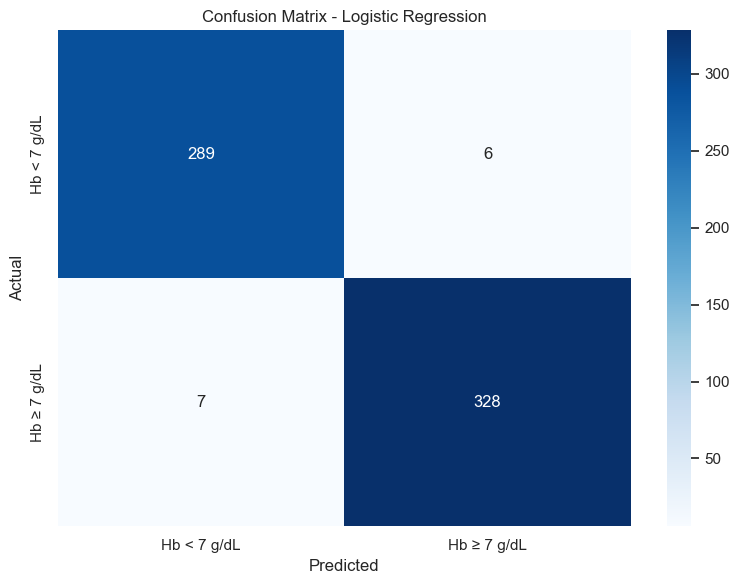


Classification Report:
              precision    recall  f1-score   support

 Hb < 7 g/dL       0.98      0.98      0.98       295
 Hb ≥ 7 g/dL       0.98      0.98      0.98       335

    accuracy                           0.98       630
   macro avg       0.98      0.98      0.98       630
weighted avg       0.98      0.98      0.98       630



In [18]:
# Evaluate logistic regression model
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression Model Performance:")
print(f"AUROC: {auroc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'],
            yticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                           target_names=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL']))

In [19]:
# Extract feature names and coefficients
# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Extract coefficients
logistic_model = logistic_pipeline.named_steps['classifier']
coefficients = logistic_model.coef_[0]

# Check lengths match before creating the dataframe
print(f"Number of feature names: {len(feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Create feature importance dataframe
if len(feature_names) == len(coefficients):
    # Create odds ratios
    odds_ratios = np.exp(coefficients)
    
    # Combine feature names, coefficients, and odds ratios
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Odds Ratio': odds_ratios
    })
    
    # Sort by coefficient magnitude
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)
    
    # Display top features overall
    print("\nTop Features Affecting Transfusion Decision:")
    display(feature_importance_sorted.head(20))
else:
    print("Warning: Feature names and coefficients length mismatch. Using generic feature names.")
    feature_names = [f"Feature_{i}" for i in range(len(coefficients))]
    odds_ratios = np.exp(coefficients)
    
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Odds Ratio': odds_ratios
    })
    
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)
    
    print("\nTop Features Affecting Transfusion Decision (using generic names):")
    display(feature_importance_sorted.head(20))

Number of feature names: 134
Number of coefficients: 134

Top Features Affecting Transfusion Decision:


,Feature,Coefficient,Odds Ratio
123,num__hemoglobin,9.632022,15245.229192
130,num__Hematocrit,1.899376,6.681724
63,cat__age_80,-0.760341,0.467507
41,cat__age_58,0.722099,2.058751
69,cat__age_86,-0.700621,0.496277
50,cat__age_67,0.653939,1.923101
79,cat__physicianspeciality_family practice,-0.598470,0.549652
112,cat__age_group_30-39,-0.532707,0.587013
65,cat__age_82,0.522508,1.686251
74,cat__teachingstatus_False,-0.488823,0.613348


C:\Users\steve\AppData\Local\Temp\ipykernel_12740\1796131429.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)


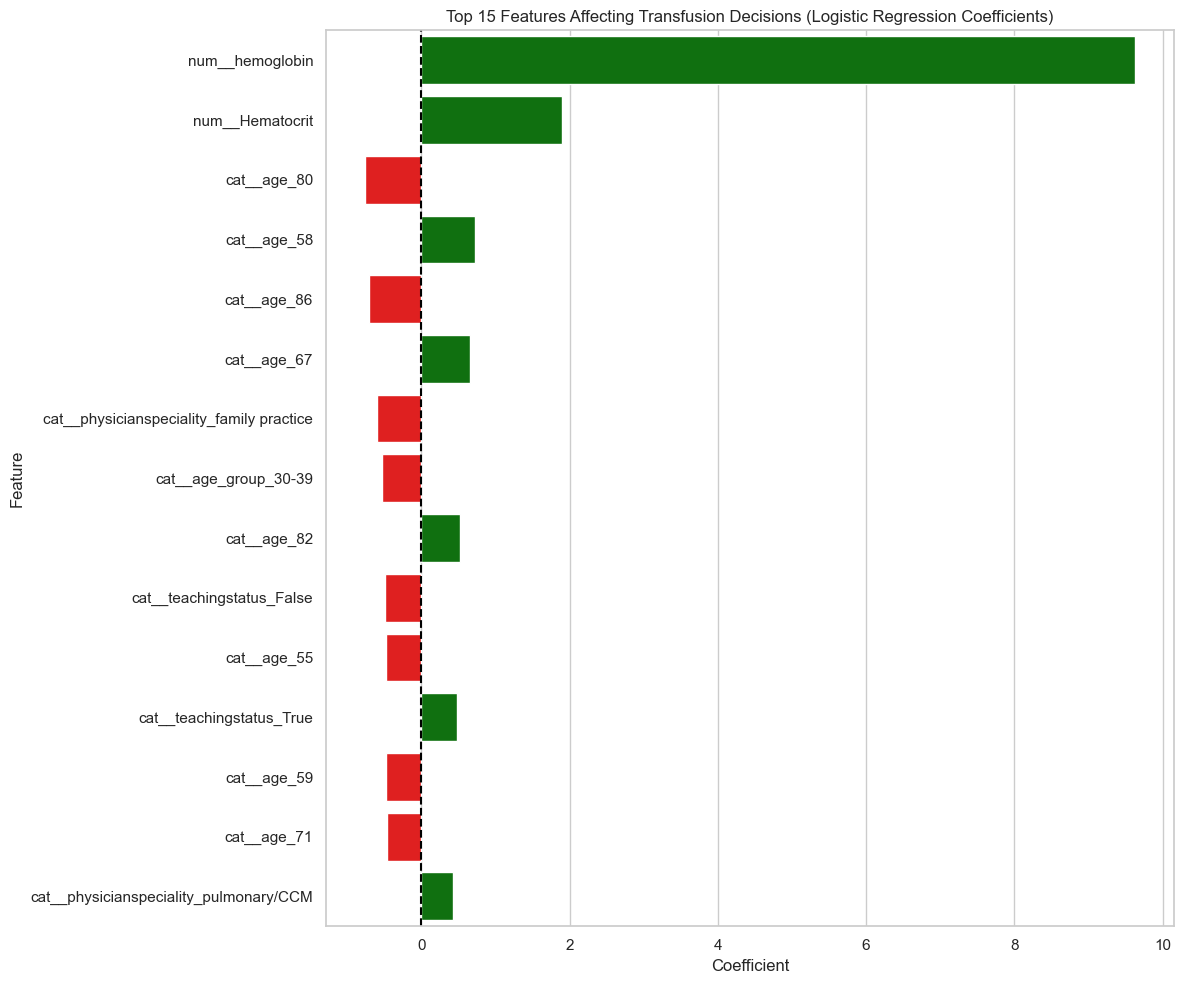

In [20]:
# Plot top coefficients
plt.figure(figsize=(12, 10))
top_features = feature_importance_sorted.head(15)
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
plt.title('Top 15 Features Affecting Transfusion Decisions (Logistic Regression Coefficients)')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

## 8. XGBoost Model with SHAP Interpretation

In [21]:
# Apply the preprocessor to training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='logloss'
)

# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    early_stopping_rounds=10,
    verbose=False
)

# Make predictions
xgb_y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_preprocessed)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# Evaluate XGBoost model
xgb_auroc = roc_auc_score(y_test, xgb_y_pred_proba)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)

print("XGBoost Model Performance:")
print(f"AUROC: {xgb_auroc:.3f}")
print(f"Precision: {xgb_precision:.3f}")
print(f"Recall: {xgb_recall:.3f}")
print(f"F1 Score: {xgb_f1:.3f}")

# Display confusion matrix
xgb_cm = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'],
            yticklabels=['Hb < 7 g/dL', 'Hb ≥ 7 g/dL'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

# Compare model performance
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'AUROC': [auroc, xgb_auroc],
    'Precision': [precision, xgb_precision],
    'Recall': [recall, xgb_recall],
    'F1 Score': [f1, xgb_f1]
})

display(model_comparison)

In [ ]:
# Get feature importance from XGBoost
importances = xgb_model.feature_importances_

# Check if feature names match importances length
if len(feature_names) == len(importances):
    # Create feature importance dataframe
    xgb_feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
else:
    # Use generic feature names
    xgb_feature_importance = pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in range(len(importances))],
        'Importance': importances
    }).sort_values('Importance', ascending=False)

# Display top features
print("Top Features from XGBoost:")
display(xgb_feature_importance.head(20))

# Plot top features
plt.figure(figsize=(12, 10))
top_xgb_features = xgb_feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_xgb_features, color='skyblue')
plt.title('Top 15 Features Affecting Transfusion Decisions (XGBoost Feature Importance)')
plt.tight_layout()
plt.show()

In [ ]:
# SHAP values for model interpretation
try:
    # Create explainer
    print("Generating SHAP values for model interpretation...")
    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_test_preprocessed)
    
    # Summary plot with feature names if they match
    if len(feature_names) == X_test_preprocessed.shape[1]:
        print("\nSHAP Summary Plot with Feature Names:")
        shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, max_display=20)
    else:
        print("\nSHAP Summary Plot (generic feature names):")
        shap.summary_plot(shap_values, X_test_preprocessed, max_display=20)
except Exception as e:
    print(f"Error generating SHAP values: {e}")
    print("Skipping SHAP analysis due to error.")

## 9. Analysis by Shock Status

In [ ]:
# Analyze the impact of variables on transfusion decisions, separately for shock and non-shock patients
# First, create a function to train and evaluate models on subgroups
def train_evaluate_subgroup(df_subgroup, group_name):
    X_subgroup = df_subgroup[categorical_features + numerical_features].copy()
    y_subgroup = df_subgroup['transfused_above_7'].copy()
    
    # Split into train and test sets
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subgroup, y_subgroup, test_size=0.3, random_state=42, stratify=y_subgroup
    )
    
    # Apply preprocessing
    X_train_sub_processed = preprocessor.fit_transform(X_train_sub)
    X_test_sub_processed = preprocessor.transform(X_test_sub)
    
    # Train XGBoost model
    subgroup_model = xgb.XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=3, 
        random_state=42,
        eval_metric='logloss'
    )
    
    # Check if we have enough samples
    if len(y_train_sub) > 20 and len(y_test_sub) > 10:
        subgroup_model.fit(
            X_train_sub_processed, y_train_sub,
            eval_set=[(X_test_sub_processed, y_test_sub)],
            early_stopping_rounds=10,
            verbose=False
        )
        
        # Get feature importance
        importances = subgroup_model.feature_importances_
        
        # Create feature importance dataframe
        if len(feature_names) == len(importances):
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
        else:
            importance_df = pd.DataFrame({
                'Feature': [f"Feature_{i}" for i in range(len(importances))],
                'Importance': importances
            }).sort_values('Importance', ascending=False)
        
        # Get model performance
        y_pred = subgroup_model.predict(X_test_sub_processed)
        y_pred_proba = subgroup_model.predict_proba(X_test_sub_processed)[:, 1]
        
        auc = roc_auc_score(y_test_sub, y_pred_proba)
        accuracy = (y_pred == y_test_sub).mean()
        
        return importance_df, auc, accuracy, subgroup_model
    else:
        print(f"Not enough samples for {group_name} group. Training: {len(y_train_sub)}, Testing: {len(y_test_sub)}")
        return None, None, None, None

In [ ]:
# Train models on shock and non-shock patients
print("Training models for shock and non-shock patient subgroups...")

shock_importance, shock_auc, shock_accuracy, shock_model = train_evaluate_subgroup(
    shock_patients, "Shock Patients"
)

non_shock_importance, non_shock_auc, non_shock_accuracy, non_shock_model = train_evaluate_subgroup(
    non_shock_patients, "Non-Shock Patients"
)

# Display results for shock patients
if shock_importance is not None:
    print(f"\nShock Patients Model - AUC: {shock_auc:.3f}, Accuracy: {shock_accuracy:.3f}")
    print("\nTop features for predicting transfusion above 7 g/dL in SHOCK patients:")
    display(shock_importance.head(10))
    
    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=shock_importance.head(10), color='tomato')
    plt.title('Top Features for Predicting Transfusion Above 7 g/dL in Shock Patients')
    plt.tight_layout()
    plt.show()

# Display results for non-shock patients
if non_shock_importance is not None:
    print(f"\nNon-Shock Patients Model - AUC: {non_shock_auc:.3f}, Accuracy: {non_shock_accuracy:.3f}")
    print("\nTop features for predicting transfusion above 7 g/dL in NON-SHOCK patients:")
    display(non_shock_importance.head(10))
    
    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=non_shock_importance.head(10), color='skyblue')
    plt.title('Top Features for Predicting Transfusion Above 7 g/dL in Non-Shock Patients')
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare the top features between shock and non-shock patients
if shock_importance is not None and non_shock_importance is not None:
    # Merge the importance dataframes
    feature_comparison = pd.merge(
        shock_importance.head(20), 
        non_shock_importance.head(20),
        on='Feature', 
        how='outer',
        suffixes=('_shock', '_non_shock')
    ).fillna(0)
    
    # Calculate the difference in importance
    feature_comparison['importance_diff'] = feature_comparison['Importance_shock'] - feature_comparison['Importance_non_shock']
    feature_comparison['abs_diff'] = abs(feature_comparison['importance_diff'])
    
    # Display features with the largest differences
    print("Features with the largest difference in importance between shock and non-shock patients:")
    display(feature_comparison.sort_values('abs_diff', ascending=False).head(10))
    
    # Plot the differences
    top_diff_features = feature_comparison.sort_values('abs_diff', ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    plt.barh(top_diff_features['Feature'], top_diff_features['importance_diff'], color=['red' if x < 0 else 'green' for x in top_diff_features['importance_diff']])
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title('Difference in Feature Importance Between Shock and Non-Shock Patients')
    plt.xlabel('Importance in Shock Patients - Importance in Non-Shock Patients')
    plt.tight_layout()
    plt.show()

## 10. Fairness Analysis

In [ ]:
# Function to perform fairness analysis for a demographic feature
def fairness_analysis(demographic_feature):
    if demographic_feature not in df_main.columns:
        print(f"Feature '{demographic_feature}' not found in the dataset")
        return None
    
    # Calculate actual transfusion rates by demographic group
    actual_rates = df_main.groupby(demographic_feature)['transfused_above_7'].mean().reset_index()
    actual_rates.columns = ['Category', 'Actual_Rate']
    actual_rates['Actual_Above_7'] = (actual_rates['Actual_Rate'] * 100).round(1).astype(str) + '%'
    
    # Get predictions from the model for each demographic group
    results = []
    
    for category in df_main[demographic_feature].unique():
        # Get subset of data for this category
        category_data = df_main[df_main[demographic_feature] == category]
        
        if len(category_data) < 10:  # Skip groups with very few samples
            continue
            
        # Apply preprocessing and predict
        X_category = category_data[categorical_features + numerical_features]
        X_category_preprocessed = preprocessor.transform(X_category)
        y_pred = logistic_pipeline.predict(X_category)
        
        # Calculate predicted transfusion rate
        predicted_rate = y_pred.mean()
        
        # Calculate actual vs. predicted difference
        actual_rate = category_data['transfused_above_7'].mean()
        difference = predicted_rate - actual_rate
        
        results.append({
            'Category': category,
            'Sample_Size': len(category_data),
            'Actual_Rate': actual_rate,
            'Predicted_Rate': predicted_rate,
            'Difference': difference
        })
    
    # Create dataframe of results
    fairness_df = pd.DataFrame(results)
    fairness_df['Actual_Above_7'] = (fairness_df['Actual_Rate'] * 100).round(1).astype(str) + '%'
    fairness_df['Predicted_Above_7'] = (fairness_df['Predicted_Rate'] * 100).round(1).astype(str) + '%'
    fairness_df['Difference'] = (fairness_df['Difference'] * 100).round(1)
    
    # Sort by sample size
    fairness_df = fairness_df.sort_values('Sample_Size', ascending=False)
    
    return fairness_df[['Category', 'Sample_Size', 'Actual_Above_7', 'Predicted_Above_7', 'Difference']]

In [ ]:
# Perform fairness analysis for demographic features
demographic_features_for_fairness = ['race', 'gender', 'age_group']
if 'insurance' in df_main.columns:
    demographic_features_for_fairness.append('insurance')
if 'region' in df_main.columns:
    demographic_features_for_fairness.append('region')
if 'teachingstatus' in df_main.columns:
    demographic_features_for_fairness.append('teachingstatus')

for feature in demographic_features_for_fairness:
    print(f"\nFairness Analysis for {feature}:")
    fairness_results = fairness_analysis(feature)
    if fairness_results is not None:
        display(fairness_results)
        
        # Create visualization
        if len(fairness_results) > 1:  # Only if we have more than one category
            plt.figure(figsize=(12, 6))
            
            # Plot the difference between predicted and actual
            sns.barplot(x='Category', y='Difference', data=fairness_results, 
                       palette=['red' if x < 0 else 'green' for x in fairness_results['Difference']])
            
            plt.axhline(y=0, color='black', linestyle='--')
            plt.title(f'Disparity in Predicted vs Actual Transfusion Rates by {feature}')
            plt.ylabel('Difference in Percentage Points (Predicted - Actual)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

## 11. Key Findings and Conclusions

### Summary of Findings

1. **Adherence to 7 g/dL Guideline**:
   - Percentage of transfusions occurring above the 7 g/dL threshold
   - Comparison between shock and non-shock patients

2. **Key Predictors of Transfusion Above 7 g/dL**:
   - Top patient factors associated with higher transfusion thresholds
   - Top provider/system factors associated with higher transfusion thresholds
   - Differences in predictors between shock and non-shock patients

3. **Fairness Assessment**:
   - Any disparities in transfusion practices based on race, gender, age, etc.
   - Potential biases in decision-making

4. **Clinical Implications**:
   - Recommendations for improving adherence to guidelines
   - Areas for potential quality improvement initiatives
   - Special considerations for shock patients
